In [52]:
library(tidyverse)
library(cansim)
library(readr)
library(vroom)
library(lubridate)
library(tseries)
library(strucchange)
library(purrr) 
library(vars)
library(fredr)

In [53]:
fredr_set_key('b43b23bac4c602369428a1a4316f23d4')


- import price index
- elasticity of import demand (2%)
- indeed real time wage inflation
- reliability of data? 
- harvard pricing lab
- eric santor
- 

In [54]:
all_tarrif_data <- read_csv("C:/Users/Irene/governorschallenge/DataWeb-Query-Export.csv")

general_import_charges <- all_tarrif_data|>
filter(`Data Type` == "General Import Charges")|>
dplyr::select(Year, Month, `General Customs Value`)|>
rename(VALUE = `General Customs Value`)|>
mutate(
    Date = ymd(paste(Year, Month, "01", sep = "-")),
    VALUE = as.numeric(VALUE)
  ) |>
  dplyr::select(Date, VALUE)|>
  arrange(Date)|>
  glimpse()

general_customs_value <- all_tarrif_data|>
filter(`Data Type` == "General Customs Value")|>
dplyr::select(Year, Month, `General Customs Value`)|>
rename(VALUE = `General Customs Value`)|>
mutate(
    Date = ymd(paste(Year, Month, "01", sep = "-")),
    VALUE = as.numeric(VALUE)
  ) |>
  dplyr::select(Date, VALUE)|>
  arrange(Date)|>
  glimpse()



tarrif_rate_df <- inner_join(
  general_import_charges, 
  general_customs_value, 
  by = "Date",
  suffix = c("_charges", "_value")
) |>
  
  # 2. Calculate the approximate tariff rate using the two VALUE columns
  mutate(
    Approximate_Rate = (VALUE_charges / VALUE_value) * 100
  ) |>
  rename(month = Date)|>
  # 3. Keep only the columns you need for your VAR model
  dplyr::select(month, Approximate_Rate)

# --- Check the final result ---
glimpse(tarrif_rate_df)

Rows: 616 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Data Type, Year, Month, General Customs Value

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 306
Columns: 2
$ Date  <date> 2000-01-01, 2000-02-01, 2000-03-01, 2000-04-01, 2000-05-01, 200…
$ VALUE <dbl> 269869762, 278547963, 305301730, 290530227, 301763964, 297764412…
Rows: 306
Columns: 2
$ Date  <date> 2000-01-01, 2000-02-01, 2000-03-01, 2000-04-01, 2000-05-01, 200…
$ VALUE <dbl> 17705142820, 18087403941, 20618285791, 18506995213, 19558432594,…
Rows: 306
Columns: 2
$ month            <date> 2000-01-01, 2000-02-01, 2000-03-01, 2000-04-01, 2000…
$ Approximate_Rate <dbl> 1.524245, 1.540011, 1.480733, 1.569840, 1.542884, 1.4…


In [55]:

### EXCHANGE RATE US-CANADA ###
exc_rate <- fredr(
  series_id = "DEXCAUS",
  observation_start = as.Date("1990-01-01"),
  observation_end = as.Date("2025-08-01"),
  frequency = "m", # monthly
  units = "chg" # change over previous value
)

### TRADE COMMODITIES US-CANADA ###
trade_commodities <- fredr(
  series_id = "XTNTVA01CAM664S",
  observation_start = as.Date("1990-01-01"),
  observation_end = as.Date("2025-08-01"),
  frequency = "m", # monthly
  units = "chg" # change over previous value
)


### TRADE POLICY UNCERTAINTY INDEX ###
tpu_data <- read_csv("Categorical_EPU_Data.csv")|>
mutate(Date = ymd(paste(Year, Month, "01", sep = "-")))|>
rename(VALUE = '9. Trade policy')|>
glimpse()


### lFS MICRO ###
lfs_micro <- read_csv('C:/Users/Irene/governorschallenge/INDINF_WAGES_MONTHLY.csv', skip=20)|>
dplyr::select(date, INDINF_LFSMICRO_M)|>
rename(Date = date, VALUE = INDINF_LFSMICRO_M)|>
  mutate(Date = mdy(Date)) |>
  filter(Date > ymd("2000-12-31"))|>
glimpse()

### SURVEY - ABILITY TO MEET PRODUCTION DEMAND ###

# ppc_data <- read_csv('C:/Users/Irene/governorschallenge/CAPACITYSIGNIF,CAPACITYSOME-sd-1999-07-01-ed-2025-07-01.csv', skip = 9) |>
#   dplyr::select(date, CAPACITYSIGNIF) |>
#   rename(Date = date, VALUE = CAPACITYSIGNIF) |>
#   # Use yq() to correctly parse the "Year-Quarter" format
#   mutate(Date = yq(Date)) |>
#   filter(Date > ymd("2000-12-31"))

# Add refresh = TRUE to each call to bypass the cache
gdp_vec <- get_cansim_vector_for_latest_periods("v65201210", periods = 300, refresh = TRUE)
cpi_vec <- get_cansim_vector_for_latest_periods("v41690973", periods = 300, refresh = TRUE) # CHANGE IN CPI
# exc_vec <- get_cansim_vector_for_latest_periods("v111666275", periods = 300, refresh = TRUE)
# oil_vec <- get_cansim_vector_for_latest_periods('v1352087861', periods = 600, refresh = TRUE)
unemp_vec <- get_cansim_vector_for_latest_periods('v2062815', periods = 500, refresh = TRUE) # UNEMPLOYMENT RATE
# ulc_vec <- get_cansim_vector_for_latest_periods('v29509282', periods = 300, refresh = TRUE) 
fcpi_vec <- get_cansim_vector_for_latest_periods('v52673496', periods = 500, refresh = TRUE) ## FISHER COMMODITY PRICE INDEX

wti_price_monthly <- fredr::fredr(series_id = "MCOILWTICO") ## CRUDE OUL PRICES -- WEST TEXAS INTERMEDIATE

# The data goes back to 1986
print(head(wti_price_monthly))

Rows: 488 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Year
dbl (2): Month, 9. Trade policy

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
"There was 1 warning in `mutate()`.
ℹ In argument: `Date = ymd(paste(Year, Month, "01", sep = "-"))`.
Caused by warning:
!  1 failed to parse."


Rows: 488
Columns: 4
$ Year  <chr> "1985", "1985", "1985", "1985", "1985", "1985", "1985", "1985", …
$ Month <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9…
$ VALUE <dbl> 122.61396, 41.76222, 107.92573, 194.75287, 124.39166, 153.16361,…
$ Date  <date> 1985-01-01, 1985-02-01, 1985-03-01, 1985-04-01, 1985-05-01, 198…


Rows: 390 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): date
dbl (7): INDINF_LFSMICRO_M, INDINF_LFSMICRO_LEVELS_M, INDINF_LFSWC_M, INDINF...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 294
Columns: 2
$ Date  <date> 2001-01-01, 2001-02-01, 2001-03-01, 2001-04-01, 2001-05-01, 200…
$ VALUE <dbl> 2.8, 3.3, 3.4, 3.3, 3.6, 3.3, 3.3, 3.1, 3.0, 3.0, 3.2, 3.4, 3.2,…


Accessing CANSIM NDM vectors from Statistics Canada

Accessing CANSIM NDM vectors from Statistics Canada

Accessing CANSIM NDM vectors from Statistics Canada

Accessing CANSIM NDM vectors from Statistics Canada



# A tibble: 6 × 5
  date       series_id  value realtime_start realtime_end
  <date>     <chr>      <dbl> <date>         <date>      
1 1986-01-01 MCOILWTICO  22.9 2025-08-22     2025-08-22  
2 1986-02-01 MCOILWTICO  15.5 2025-08-22     2025-08-22  
3 1986-03-01 MCOILWTICO  12.6 2025-08-22     2025-08-22  
4 1986-04-01 MCOILWTICO  12.8 2025-08-22     2025-08-22  
5 1986-05-01 MCOILWTICO  15.4 2025-08-22     2025-08-22  
6 1986-06-01 MCOILWTICO  13.4 2025-08-22     2025-08-22  


In [56]:
## BREAK EVEN INFLATION RATE

monthly_real_return_bond <- get_cansim_vector_for_latest_periods('v122553',periods = 500)
monthly_convetional_bond <- get_cansim_vector_for_latest_periods('v122543',periods = 500)
monthly_real_return_bond <- monthly_real_return_bond|>
dplyr::select(Date, VALUE)

monthly_convetional_bond <- monthly_convetional_bond|>
dplyr::select(Date, VALUE)

break_even_df <- monthly_convetional_bond |>
  inner_join(monthly_real_return_bond, by = "Date", suffix = c("_conventional", "_real_return")) |>
  mutate(break_even_inflation_rate = VALUE_conventional - VALUE_real_return) |>
  dplyr::select(Date, break_even_inflation_rate)

  glimpse(
break_even_df)

Reading CANSIM NDM vectors from temporary cache

Reading CANSIM NDM vectors from temporary cache



Rows: 500
Columns: 2
$ Date                      <date> 1984-01-01, 1984-02-01, 1984-03-01, 1984-04…
$ break_even_inflation_rate <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …


In [57]:
policy_rate_daily_vec <- get_cansim_vector("v39050", start_time = "2000-01-01")

Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/Toronto'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'GMT'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/New_York'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/Los_Angeles'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'GMT'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/New_York'"
Reading CANSIM NDM vectors from temporary cache



In [58]:
start_date <- "1990-01-01"

# # --- GDP ---
gdp_monthly <- gdp_vec |>
  dplyr::select(Date, VALUE) |>
  # Create a 'month' column and filter
  dplyr::mutate(month = lubridate::floor_date(Date, "month")) |>
  dplyr::filter(month >= start_date) |>
  # Calculate month-over-month percent change
  dplyr::mutate(
    delta_gdp = (log(VALUE) - log(dplyr::lag(VALUE, 1))) * 100
  ) |>
  dplyr::select(month, delta_gdp) |>
  tidyr::drop_na()

# --- Break-even Inflation Rate ---
bond_monthly <- break_even_df |>
  dplyr::select(Date, break_even_inflation_rate) |>
  dplyr::mutate(month = lubridate::floor_date(Date, "month")) |>
  dplyr::filter(month >= start_date) |>
  dplyr::mutate(
    delta_bond = (log(break_even_inflation_rate) - log(dplyr::lag(break_even_inflation_rate, 1))) * 100
  ) |>
  dplyr::select(month, delta_bond) |>
  tidyr::drop_na()

# ppc_monthly <- ppc_data |>
#   dplyr::select(Date, VALUE) |>
#   dplyr::mutate(month = lubridate::floor_date(Date, "month")) |>
#   dplyr::filter(month >= start_date) |>
#   dplyr::mutate(
#     delta_ppc = VALUE
#   ) |>
#   dplyr::select(month, delta_ppc) |>
#   tidyr::drop_na()


# --- Policy Interest Rate (Level) ---
policy_rate_monthly <- policy_rate_daily_vec |>
  dplyr::select(Date, VALUE) |>
  # Create a 'month' column to group by
  mutate(month = floor_date(Date, "month")) |>
  # Group by month and calculate the average rate
  group_by(month) |>
  summarise(
    policy_rate = mean(VALUE, na.rm = TRUE) # Calculate the monthly average
  ) |>
  mutate(policy_rate  = (log(policy_rate) - log(dplyr::lag(policy_rate, 1))) * 100) |>
  ungroup()

# --- Oil ---
oil_monthly <- wti_price_monthly |>
  dplyr::select(date, value) |>
  dplyr::mutate(month = date) |>
  dplyr::filter(month >= start_date) |>
  dplyr::mutate(
    delta_oil = (log(value) - log(dplyr::lag(value, 1))) * 100
  ) |>
  dplyr::select(month, delta_oil) |>
  tidyr::drop_na()

trade_unc_monthly <- tpu_data |>
  dplyr::select(Date, VALUE) |>
  dplyr::mutate(month = Date) |>
  dplyr::filter(month >= start_date) |>
  dplyr::mutate(
    delta_trade_unc = (log(VALUE) - log(dplyr::lag(VALUE, 1))) * 100
  ) |>
  dplyr::select(month, delta_trade_unc) |>
  tidyr::drop_na()

# --- No changes needed for your inflation calculation ---
cpi_monthly <- cpi_vec |>
  dplyr::select(Date, VALUE) |>
  dplyr::mutate(month = Date) |>
  dplyr::arrange(month) |> # Good practice to sort by date before lagging
  dplyr::mutate(delta_cpi = (VALUE / dplyr::lag(VALUE, 12) - 1)*100)|>
  dplyr::select(month, delta_cpi) |>
  tidyr::drop_na()

fcpi_monthly <- fcpi_vec |>
  dplyr::select(Date, VALUE) |>
  dplyr::mutate(month = Date) |>
  dplyr::arrange(month) |> # Good practice to sort by date before lagging
  dplyr::mutate(
    delta_fcpi = (log(VALUE) - log(dplyr::lag(VALUE, 1))) * 100
  ) |>
  dplyr::select(month, delta_fcpi) |>
  tidyr::drop_na()|>
  glimpse()

# --- ULC (if you decide to use it, assuming it's monthly) ---
# ulc_monthly <- ulc_vec |>
#   dplyr::select(Date, VALUE) |>
#   dplyr::mutate(month = lubridate::floor_date(Date, "month")) |>
#   dplyr::filter(month >= start_date) |>
#   dplyr::mutate(
#     delta_ulc = (log(VALUE) - log(dplyr::lag(VALUE, 1))) * 100
#   ) |>
#   dplyr::select(month, delta_ulc) |>
#   tidyr::drop_na()


trade_commodities_monthly <- trade_commodities |>
  dplyr::select(date, value) |>
  dplyr::mutate(month = date) |>
  dplyr::filter(month >= start_date) |>
  dplyr::mutate(
    trade_us_canada = value) |>
  dplyr::select(month, trade_us_canada ) |>
  tidyr::drop_na()

lfs_micro_monthly <- lfs_micro |>
  dplyr::select(Date, VALUE) |>
  dplyr::mutate(month = Date) |>
  dplyr::filter(month >= start_date) |>
  dplyr::mutate(
    lfs_micro = (log(VALUE) - log(dplyr::lag(VALUE, 1))) * 100) |>
  dplyr::select(month, lfs_micro) |>
  tidyr::drop_na()

# Process Exchange Rate (quarterly percent change)
# exc_quarterly <- exc_vec |>
#   dplyr::select(Date, VALUE) |>
#   dplyr::mutate(quarter = lubridate::floor_date(Date, "quarter")) |>
#   dplyr::group_by(quarter) |>
#   dplyr::summarise(VALUE = dplyr::last(VALUE), .groups = 'drop') |>
#   dplyr::filter(quarter >= start_date) |> #
#   dplyr::mutate(
#     delta_exc = (log(VALUE) - log(dplyr::lag(VALUE, 1))) * 100
#   ) |>
#   dplyr::select(quarter, delta_exc) |>
#   tidyr::drop_na()

# Process Unemployment (using the rate level)
unemp_monthly <- unemp_vec |>
  dplyr::select(Date, VALUE) |>
  dplyr::mutate(month = lubridate::floor_date(Date, "month")) |>
  dplyr::filter(month >= start_date) |>
  # Using the unemployment rate level directly
  dplyr::mutate(
    delta_unemp = VALUE
  ) |>
  dplyr::select(month, delta_unemp) |>
  tidyr::drop_na()


exc_monthly <- exc_rate |>
rename(month = date)|>
rename(delta_exc = value)|>
dplyr::select(month, delta_exc)|>
tidyr::drop_na()


Rows: 499
Columns: 2
$ month      <date> 1984-01-01, 1984-02-01, 1984-03-01, 1984-04-01, 1984-05-01…
$ delta_fcpi <dbl> 1.69137224, 0.45319931, 2.09954365, -0.82079804, -1.0008711…


In [59]:
unemp_nairu <- unemp_vec |>
  dplyr::select(Date, VALUE) |>
  dplyr::mutate(month = lubridate::floor_date(Date, "month")) |>
  dplyr::filter(month >= start_date) |>
  dplyr::mutate(
    unemployment = VALUE # Renaming here is clearer
  ) |>
  dplyr::select(month, unemployment) |>
  tidyr::drop_na()

# --- THE FIX: Use inner_join() instead of cbind() ---
philips_curve <- dplyr::inner_join(unemp_nairu, cpi_monthly, by = "month") |>
  glimpse()



Rows: 288
Columns: 3
$ month        <date> 2001-08-01, 2001-09-01, 2001-10-01, 2001-11-01, 2001-12-…
$ unemployment <dbl> 7.2, 7.2, 7.3, 7.5, 8.1, 8.0, 7.9, 7.9, 7.7, 7.8, 7.6, 7.…
$ delta_cpi    <dbl> 2.8213166, 2.6014568, 1.8691589, 0.6211180, 0.7238883, 1.…


In [60]:
cpi_vec %>% dplyr::select(Date) %>% print(n = 20)


# A tibble: 300 × 1
   Date      
   <date>    
 1 2000-08-01
 2 2000-09-01
 3 2000-10-01
 4 2000-11-01
 5 2000-12-01
 6 2001-01-01
 7 2001-02-01
 8 2001-03-01
 9 2001-04-01
10 2001-05-01
11 2001-06-01
12 2001-07-01
13 2001-08-01
14 2001-09-01
15 2001-10-01
16 2001-11-01
17 2001-12-01
18 2002-01-01
19 2002-02-01
20 2002-03-01
# ℹ 280 more rows


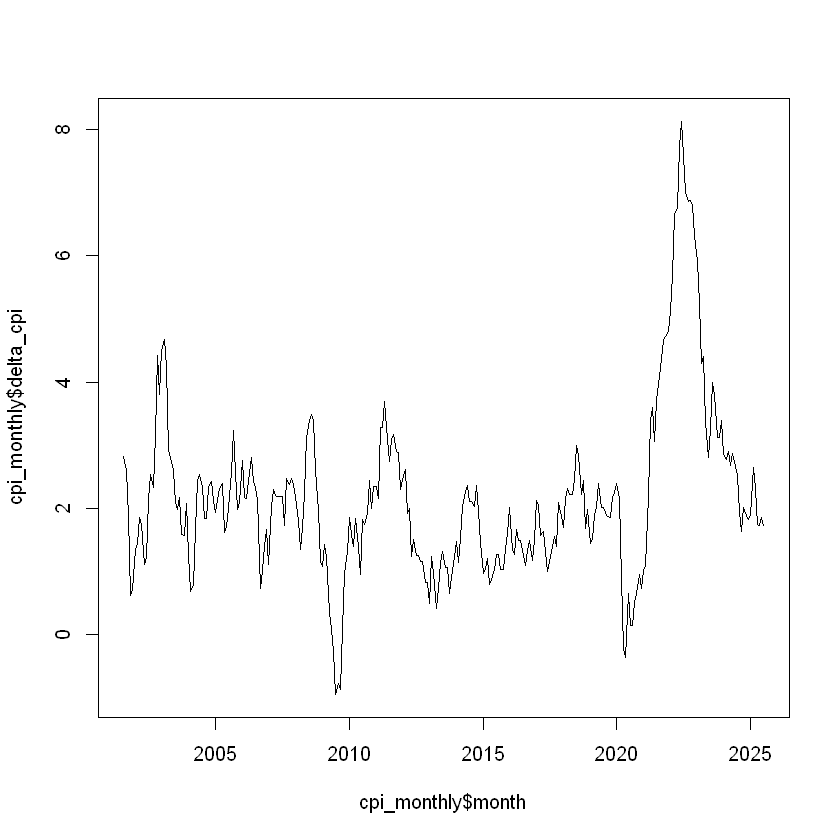

In [61]:
plot(cpi_monthly$month, cpi_monthly$delta_cpi, "l")

In [62]:
combine_processed_dfs <- function(...) {
  list_of_dfs <- list(...)
  combined_df <- purrr::reduce(list_of_dfs, dplyr::inner_join, by = "month")
  return(combined_df)
}

# Example of how to use it:
final_monthly_df <- combine_processed_dfs(
  gdp_monthly,
  oil_monthly,
  cpi_monthly,
  exc_monthly,
  unemp_monthly,
  bond_monthly,
  trade_commodities_monthly,
  trade_unc_monthly,
  fcpi_monthly,
  lfs_micro_monthly,
  tarrif_rate_df,
  policy_rate_monthly
  # ppc_monthly
)|>
filter(row_number() <= n() - 1)

glimpse(final_monthly_df)

Rows: 286
Columns: 13
$ month            <date> 2001-08-01, 2001-09-01, 2001-10-01, 2001-11-01, 2001…
$ delta_gdp        <dbl> 0.3338033, -0.5386542, 0.4557593, 0.6428197, -0.10729…
$ delta_oil        <dbl> 3.4947794, -4.3688112, -16.7019387, -12.1171721, -1.2…
$ delta_cpi        <dbl> 2.8213166, 2.6014568, 1.8691589, 0.6211180, 0.7238883…
$ delta_exc        <dbl> 0.009066046, 0.028082367, 0.003738384, 0.020567727, -…
$ delta_unemp      <dbl> 7.2, 7.2, 7.3, 7.5, 8.1, 8.0, 7.9, 7.9, 7.7, 7.8, 7.6…
$ delta_bond       <dbl> -2.231436e+01, -2.409755e+00, -2.635845e+01, 2.876821…
$ trade_us_canada  <dbl> -811300000, 959500000, -1005600000, 1796100000, -9733…
$ delta_trade_unc  <dbl> 19.752048, 90.325515, -39.894460, 6.748555, 20.723889…
$ delta_fcpi       <dbl> 0.1768973, -10.1871069, -5.1808413, -3.8660277, 1.488…
$ lfs_micro        <dbl> -6.252036, -3.278982, 0.000000, 6.453852, 6.062462, -…
$ Approximate_Rate <dbl> 1.491150, 1.488209, 1.514474, 1.487655, 1.497298, 1.4…
$ policy_rate     

In [63]:
variables_to_test <- setdiff(names(final_monthly_df), "month")

# Loop through each variable name
for (var in variables_to_test) {
  
  # Run the ADF test on the column
  adf_result <- adf.test(final_monthly_df[[var]], alternative = "stationary")
  
  # Print a formatted summary of the results
  cat("--- ADF Test for:", var, "---\n")
  cat("Dickey-Fuller Statistic:", round(adf_result$statistic, 3), "\n")
  cat("P-value:", round(adf_result$p.value, 4), "\n")
  
  # Interpret the result based on the p-value
  if (adf_result$p.value < 0.1) {
    cat("Result: The series is Stationary (p < 0.05)\n\n")
  } else {
    cat("Result: The series is Non-Stationary (p >= 0.05)\n\n")
  }
}

Warning message in adf.test(final_monthly_df[[var]], alternative = "stationary"):
"p-value smaller than printed p-value"


--- ADF Test for: delta_gdp ---
Dickey-Fuller Statistic: -7.653 
P-value: 0.01 
Result: The series is Stationary (p < 0.05)



Warning message in adf.test(final_monthly_df[[var]], alternative = "stationary"):
"p-value smaller than printed p-value"


--- ADF Test for: delta_oil ---
Dickey-Fuller Statistic: -6.891 
P-value: 0.01 
Result: The series is Stationary (p < 0.05)

--- ADF Test for: delta_cpi ---
Dickey-Fuller Statistic: -3.308 
P-value: 0.0702 
Result: The series is Stationary (p < 0.05)



Warning message in adf.test(final_monthly_df[[var]], alternative = "stationary"):
"p-value smaller than printed p-value"


--- ADF Test for: delta_exc ---
Dickey-Fuller Statistic: -6.733 
P-value: 0.01 
Result: The series is Stationary (p < 0.05)

--- ADF Test for: delta_unemp ---
Dickey-Fuller Statistic: -3.314 
P-value: 0.0692 
Result: The series is Stationary (p < 0.05)



Warning message in adf.test(final_monthly_df[[var]], alternative = "stationary"):
"p-value smaller than printed p-value"


--- ADF Test for: delta_bond ---
Dickey-Fuller Statistic: -7.542 
P-value: 0.01 
Result: The series is Stationary (p < 0.05)



Warning message in adf.test(final_monthly_df[[var]], alternative = "stationary"):
"p-value smaller than printed p-value"


--- ADF Test for: trade_us_canada ---
Dickey-Fuller Statistic: -8.357 
P-value: 0.01 
Result: The series is Stationary (p < 0.05)



Warning message in adf.test(final_monthly_df[[var]], alternative = "stationary"):
"p-value smaller than printed p-value"


--- ADF Test for: delta_trade_unc ---
Dickey-Fuller Statistic: -6.937 
P-value: 0.01 
Result: The series is Stationary (p < 0.05)



Warning message in adf.test(final_monthly_df[[var]], alternative = "stationary"):
"p-value smaller than printed p-value"


--- ADF Test for: delta_fcpi ---
Dickey-Fuller Statistic: -6.685 
P-value: 0.01 
Result: The series is Stationary (p < 0.05)



Warning message in adf.test(final_monthly_df[[var]], alternative = "stationary"):
"p-value smaller than printed p-value"


--- ADF Test for: lfs_micro ---
Dickey-Fuller Statistic: -6.959 
P-value: 0.01 
Result: The series is Stationary (p < 0.05)

--- ADF Test for: Approximate_Rate ---
Dickey-Fuller Statistic: -2.811 
P-value: 0.2344 
Result: The series is Non-Stationary (p >= 0.05)



Warning message in adf.test(final_monthly_df[[var]], alternative = "stationary"):
"p-value smaller than printed p-value"


--- ADF Test for: policy_rate ---
Dickey-Fuller Statistic: -5.071 
P-value: 0.01 
Result: The series is Stationary (p < 0.05)



In [64]:
# long_term_mean_unemp <- mean(final_monthly_df$delta_unemp, na.rm = TRUE)

# # Optional: Print the mean to see the calculated "natural rate"
# print(paste("Long-Term Mean Unemployment Rate:", round(long_term_mean_unemp, 2)))

# final_monthly_df <- final_monthly_df|>
# mutate(market_slack = delta_unemp - long_term_mean_unemp)|>
# dplyr::select(!delta_unemp)
# # 3. View the result
# glimpse(final_monthly_df)

In [65]:
df_for_lags <- final_monthly_df|>
dplyr::select(delta_cpi ,delta_exc ,delta_unemp ,delta_bond ,delta_fcpi ,lfs_micro, Approximate_Rate, policy_rate)
lag_selection <- VARselect(df_for_lags, lag.max = 16, type = "const")

print(lag_selection$selection)

df_for_lags_gdp <- final_monthly_df|>
dplyr::select(delta_cpi ,delta_exc ,delta_gdp ,delta_bond ,delta_fcpi ,lfs_micro, Approximate_Rate, policy_rate)
lag_selection <- VARselect(df_for_lags, lag.max = 16, type = "const")

print(lag_selection$selection)

AIC(n)  HQ(n)  SC(n) FPE(n) 
     2      1      1      2 
AIC(n)  HQ(n)  SC(n) FPE(n) 
     2      1      1      2 


In [66]:
var_data_cpi <- final_monthly_df |>
  dplyr::select(delta_cpi ,delta_exc ,delta_unemp ,delta_bond ,delta_fcpi ,lfs_micro, Approximate_Rate)|>
 ts(start = c(2001, 1), frequency = 12)

 var_data_gdp <- final_monthly_df |>
  dplyr::select(delta_cpi ,delta_exc ,delta_gdp ,delta_bond ,delta_fcpi ,lfs_micro, Approximate_Rate)|>
 ts(start = c(2001, 1), frequency = 12)

In [67]:

var_model_cpi <- VAR(var_data_cpi, p = 12, type = "const")

summary_cpi <- summary(var_model_cpi)

print(summary_cpi$varresult$delta_cpi)



var_model_gdp <- VAR(var_data_gdp, p = 12, type = "const")

summary_gdp <- summary(var_model_gdp)

print(summary_gdp$varresult$delta_cpi)


Call:
lm(formula = y ~ -1 + ., data = datamat)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.88038 -0.21436 -0.01515  0.20076  1.09019 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
delta_cpi.l1          0.8829812  0.0768447  11.490  < 2e-16 ***
delta_exc.l1          2.5991117  1.4233538   1.826 0.069421 .  
delta_unemp.l1        0.1288952  0.0963082   1.338 0.182386    
delta_bond.l1         0.0039002  0.0024974   1.562 0.120024    
delta_fcpi.l1         0.0253098  0.0068865   3.675 0.000309 ***
lfs_micro.l1         -0.0004595  0.0020914  -0.220 0.826318    
Approximate_Rate.l1  -0.0619126  0.2164792  -0.286 0.775193    
delta_cpi.l2         -0.1054589  0.1003839  -1.051 0.294804    
delta_exc.l2          0.5458866  1.4906624   0.366 0.714622    
delta_unemp.l2       -0.3190669  0.1747694  -1.826 0.069482 .  
delta_bond.l2         0.0019523  0.0027734   0.704 0.482335    
delta_fcpi.l2         0.0005466  0.0071280   0.077 0.938951    
l

In [69]:
# 1. Use the predict() function to forecast 1 step (month) ahead
# The object var_model_12 already contains all the necessary data.
forecast_result <- predict(var_model_cpi, n.ahead = 1)

# 2. Extract the forecast for your specific variable ('delta_cpi')
#

# 2. Apply a function to each element of the forecast list to extract the 'fcst' column
point_forecasts <- sapply(forecast_result$fcst, function(x) x[, "fcst"])

# 3. Print the result
print(point_forecasts)

       delta_cpi        delta_exc      delta_unemp       delta_bond 
      1.81032248      -0.01196987       6.77637673      -5.00616396 
      delta_fcpi        lfs_micro Approximate_Rate 
      5.96025628      -5.18589278       2.39130793 


In [88]:
svar_order <- c("Approximate_Rate", # 2. Slow-Moving Real Variables (React with a lag)
  "delta_gdp",
  "delta_unemp",
  "lfs_micro", # Assuming this is another real labor force variable
  
  # 3. Faster-Moving Price Variables 
  "delta_cpi",
  "delta_fcpi",
  
  # 4. Very Fast-Moving Financial Variables (React instantly to news)
  "delta_exc", # Exchange Rate
  "delta_bond", # Breakeven Inflation
  
  # 5. Policy Response (The reaction)
  "policy_rate" 
)

# 2. Re-order your dataframe and create the time series object
svar_data <- final_monthly_df |>
  dplyr::select(all_of(svar_order)) |>
  ts(start = c(2001, 1), frequency = 12)

# 3. Re-estimate the VAR model with the ordered data
# The Cholesky decomposition is now implicitly defined by your column order
var_model_svar <- VAR(svar_data, p = 12, type = "const")

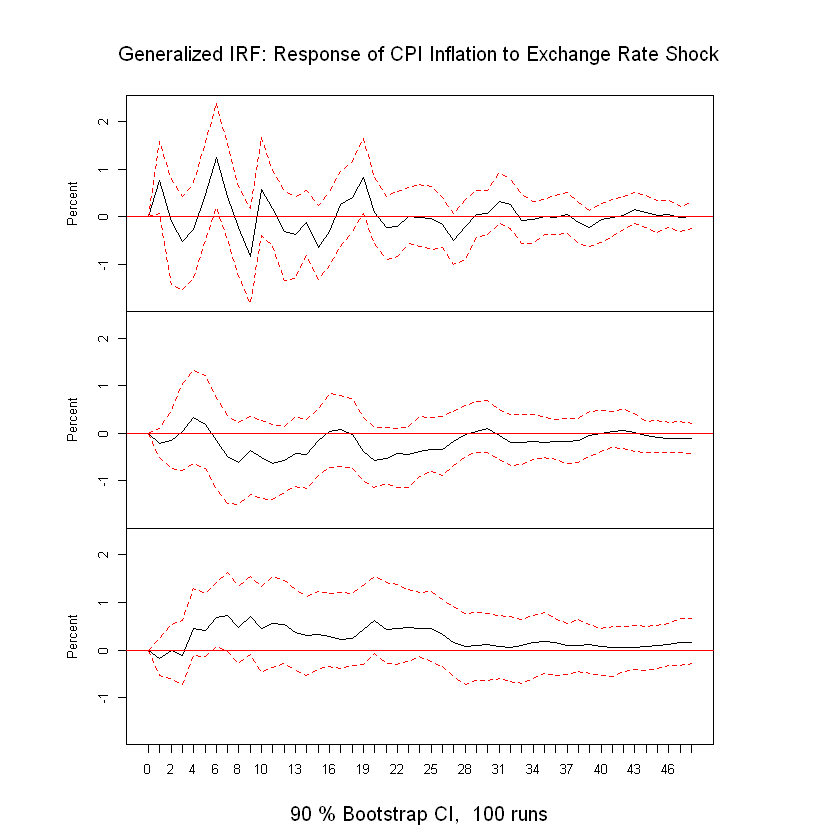

In [92]:
# 1. Your data and estimated VAR model (no changes needed here)
var_model_svar <- vars::VAR(svar_data, p = 12, type = "const")

# 2. Calculate the Generalized Impulse Response Function (GIRF) 💡
# This avoids the ordering assumption of a Cholesky decomposition.
girf_irf <- vars::irf(
  var_model_svar,
  impulse = "Approximate_Rate",
  response = c("delta_cpi", "delta_unemp", "delta_gdp"),
  n.ahead = 48,
  boot = TRUE,
  ortho = FALSE,
  ci = 0.90  # <-- This is the key change
)

# 3. Plot the GIRF
plot(girf_irf, main = "Generalized IRF: Response of CPI Inflation to Exchange Rate Shock",
     xlab = "Months", ylab = "Percent")

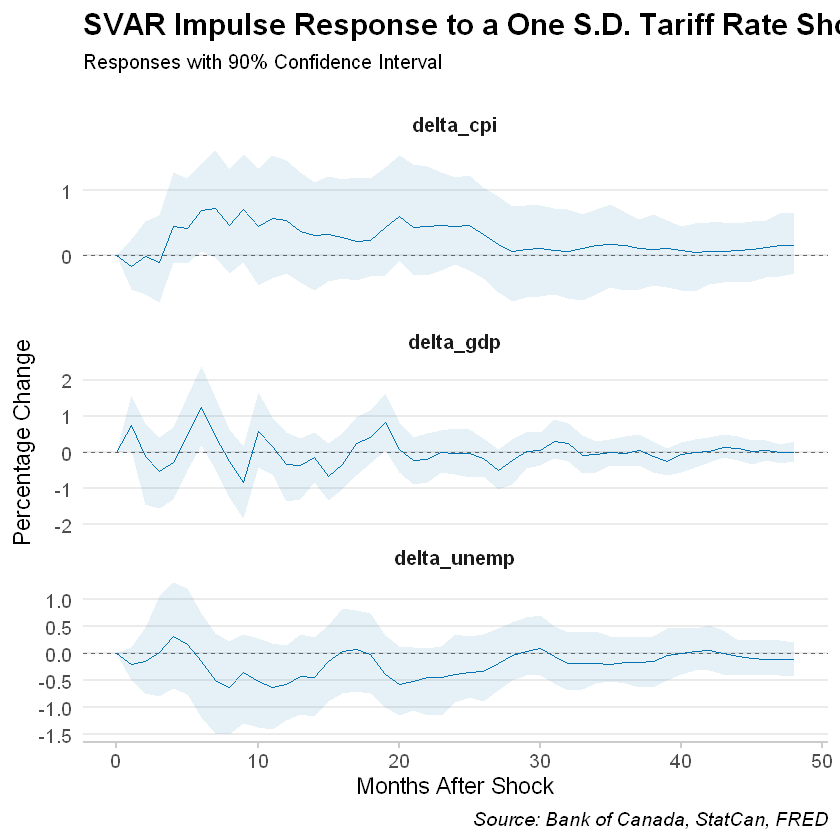

In [95]:
df_list <- lapply(1:length(girf_irf$response), function(i) {
  data.frame(
    period      = 0:(nrow(girf_irf$irf$Approximate_Rate) - 1),
    response    = girf_irf$response[i],
    impulse     = girf_irf$impulse,
    irf_value   = girf_irf$irf$Approximate_Rate[, i],
    lower_ci    = girf_irf$Lower$Approximate_Rate[, i],
    upper_ci    = girf_irf$Upper$Approximate_Rate[, i]
  )
})

# Combine the list into a single, tidy data frame
plot_df <- do.call(rbind, df_list)

# You can inspect the result
# print(head(plot_df))
#
# It should look something like this:
#
#   period   response      impulse    irf_value    lower_ci    upper_ci
# 1      0 unemp_rate  tariff_rate   0.09540000  0.01481000   0.1940000
# 2      1 unemp_rate  tariff_rate   0.10280000 -0.02502000   0.2500000
# 3      2 unemp_rate  tariff_rate   0.10510000 -0.02093000   0.2150000
# ...


#
# --- Step 2: Create the plot with ggplot2 ---
#
# The plot object is assigned to a variable 'p'
p <- ggplot(plot_df, aes(x = period)) +

  # 1. Add the zero-line for reference
  geom_hline(yintercept = 0, linetype = "dashed", color = "grey40") +

  # 2. Add the shaded confidence interval ribbon
  geom_ribbon(aes(ymin = lower_ci, ymax = upper_ci),
              fill = "#0072B2",
              alpha = 0.1, # Makes the ribbon transparent
              na.rm = TRUE) +

  # 3. Plot the main impulse response line
  geom_line(aes(y = irf_value), color = "#0072B2", size = 0.5, na.rm = TRUE) +

  # 4. Create separate plots for each response, stacked vertically
  facet_wrap(~response, scales = "free_y", ncol = 1) +

  # 5. Apply labels, title, and subtitle
  labs(
    title = "SVAR Impulse Response to a One S.D. Tariff Rate Shock",
    subtitle = "Responses with 90% Confidence Interval",
    x = "Months After Shock",
    y = "Percentage Change",
    caption = "Source: Bank of Canada, StatCan, FRED"
  ) +

  # 6. Apply a clean theme and customize it
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(face = "bold", size = 18),
    plot.subtitle = element_text(size = 12, margin = margin(b = 20)),
    plot.caption = element_text(face = "italic"),
    strip.text = element_text(face = "bold", size = 12),
    panel.grid.minor = element_blank(),
    panel.grid.major.x = element_blank(),
    axis.line.x = element_line(color = "grey80"),
    axis.ticks.x = element_line(color = "grey80")
  )
# You can now print the plot to see the result in your R session
print(p)

In [101]:
ggsave(
  "irfs_parsimonious.png", # The filename for the saved plot               # The plot object to save
  width = 6,              # Width in inches
  height = 5,              # Height in inches
  dpi = 300                # Dots per inch (resolution)
)

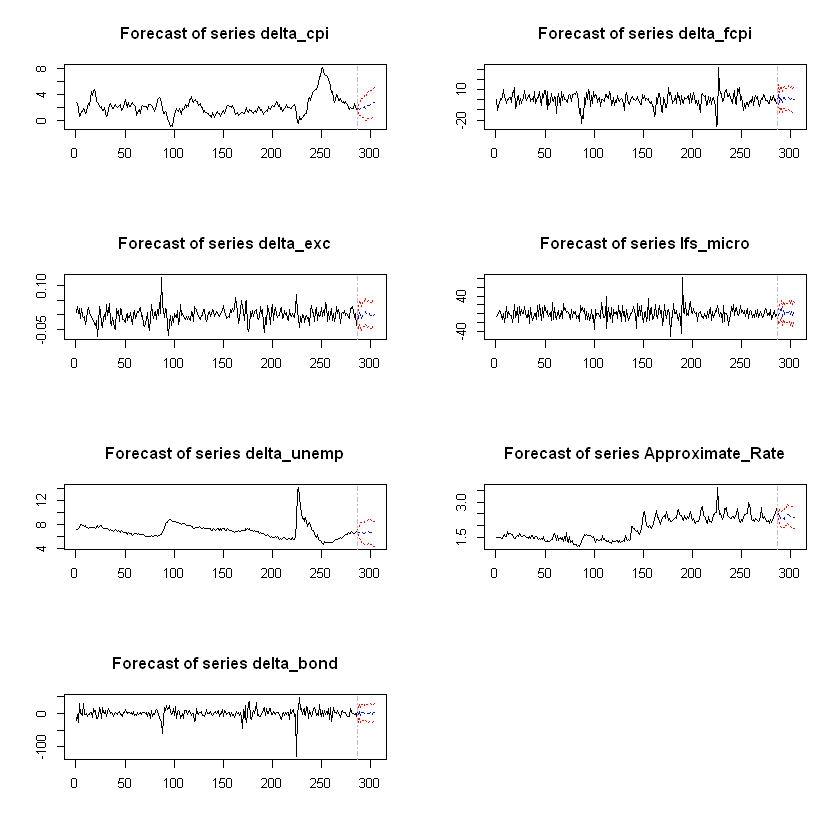

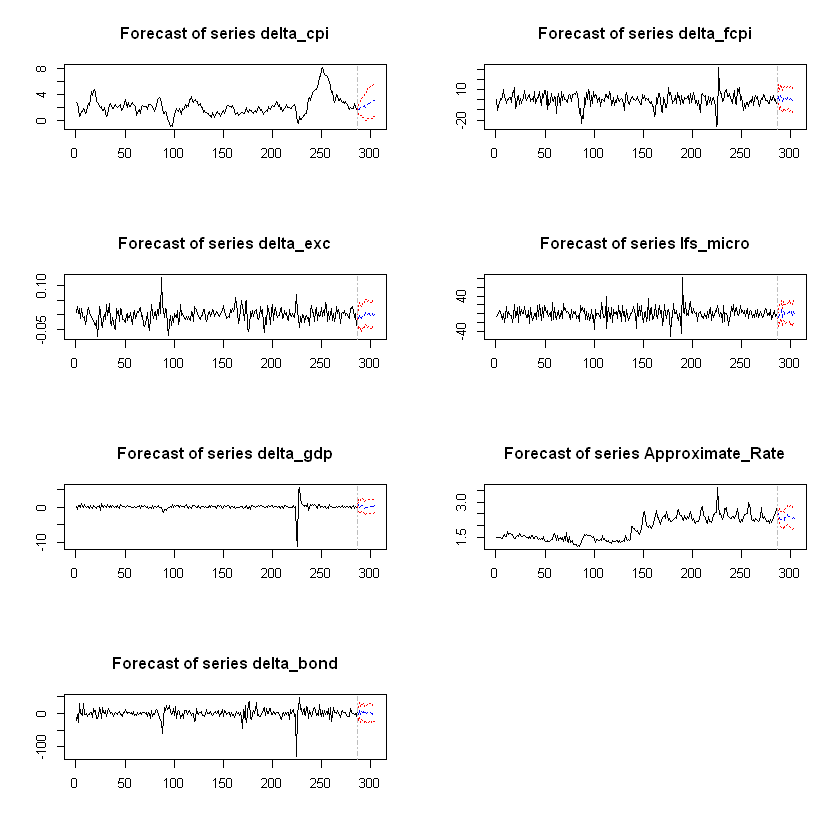

In [ ]:

forecast_results_cpi <- predict(var_model_cpi, n.ahead = 18, ci = 0.90)

plot(forecast_results_cpi)


forecast_results_gdp <- predict(var_model_gdp, n.ahead = 18, ci = 0.90)

plot(forecast_results_gdp)

In [ ]:
library(ggfortify)
library(dplyr)
library(ggplot2)
library(lubridate)

In [ ]:
forecast_df_cpi<- fortify(forecast_results_cpi)

# Inspect the new dataframe to see its structure
glimpse(forecast_df_cpi)


forecast_df_gdp<- fortify(forecast_results_gdp)

# Inspect the new dataframe to see its structure
glimpse(forecast_df_gdp)



Rows: 304
Columns: 36
$ Index                  <date> 2001-01-01, 2001-02-01, 2001-03-01, 2001-04-01…
$ delta_cpi              <dbl> 2.8213166, 2.6014568, 1.8691589, 0.6211180, 0.7…
$ delta_exc              <dbl> 0.009066046, 0.028082367, 0.003738384, 0.020567…
$ delta_unemp            <dbl> 7.2, 7.2, 7.3, 7.5, 8.1, 8.0, 7.9, 7.9, 7.7, 7.…
$ delta_bond             <dbl> -2.231436e+01, -2.409755e+00, -2.635845e+01, 2.…
$ delta_fcpi             <dbl> 0.1768973, -10.1871069, -5.1808413, -3.8660277,…
$ lfs_micro              <dbl> -6.252036, -3.278982, 0.000000, 6.453852, 6.062…
$ Approximate_Rate       <dbl> 1.491150, 1.488209, 1.514474, 1.487655, 1.49729…
$ delta_cpi.fcst         <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,…
$ delta_cpi.lower        <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,…
$ delta_cpi.upper        <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,…
$ delta_cpi.CI           <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,…
$ delta_exc.fcst  

In [ ]:
last_obs_index <- max(which(!is.na(forecast_df_cpi$delta_cpi)))

# Get the value of that last observation
last_obs_value <- forecast_df_cpi$delta_cpi[last_obs_index]

# Copy this last known value to the forecast columns FOR THAT SAME ROW
# This creates the "bridge" that connects the two lines.
forecast_df_cpi$delta_cpi.fcst[last_obs_index] <- last_obs_value
forecast_df_cpi$delta_cpi.lower[last_obs_index] <- last_obs_value
forecast_df_cpi$delta_cpi.upper[last_obs_index] <- last_obs_value

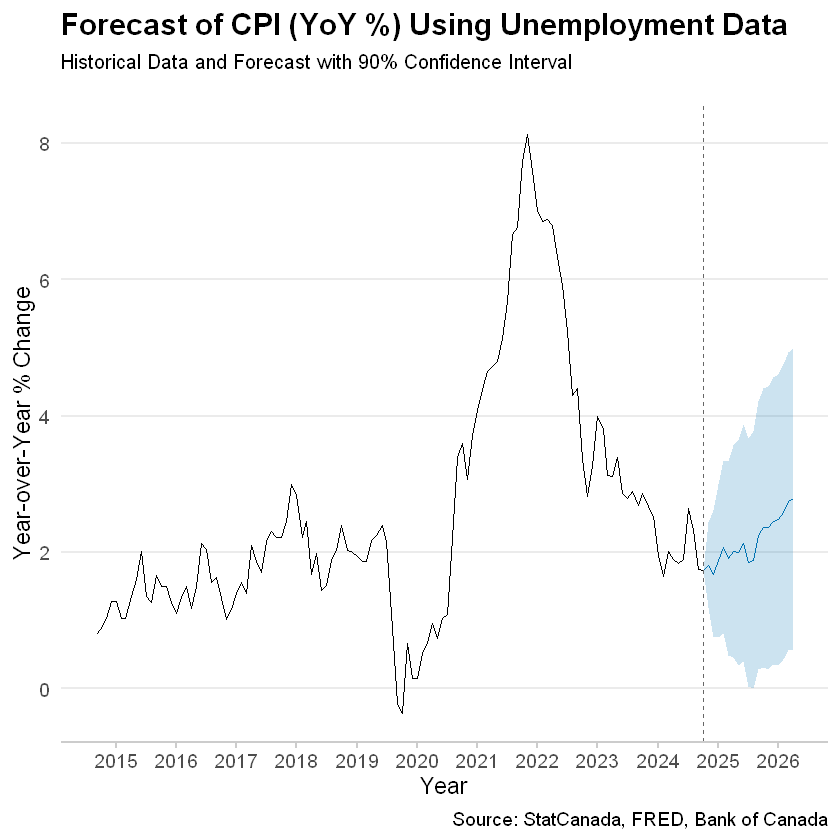

In [ ]:
# Find the last date of actual historical data before forecasts begin
last_actual_date <- forecast_df_cpi %>%
  filter(!is.na(delta_cpi) & is.na(delta_cpi.fcst)) %>%
  summarise(max_date = max(Index)) %>%
  pull(max_date)

# Determine the start date for filtering (5 years before the last actual data point)
start_date <- last_actual_date - years(10)

# Filter the dataframe to include the last 5 years of actual data plus all forecast data
plot_data <- forecast_df_cpi %>%
  filter(Index >= start_date)

# Find the date where the forecast officially begins
forecast_start_date <- plot_data %>%
  filter(!is.na(delta_cpi.fcst)) %>%
  summarise(min_date = min(Index)) %>%
  pull(min_date)

# Create the plot
ggplot(plot_data, aes(x = Index)) +
  # 1. Plot the historical data line (in black)
  geom_line(aes(y = delta_cpi), color = "black", size = 0.5, na.rm = TRUE) +
  
  # 2. Plot the forecast line (in blue)
  geom_line(aes(y = delta_cpi.fcst), color = "#0072B2", size = 0.5, na.rm = TRUE) +
  
  # 3. Add the shaded confidence interval ribbon
  geom_ribbon(aes(ymin = delta_cpi.lower, ymax = delta_cpi.upper), 
              fill = "#0072B2", 
              alpha = 0.2,    # alpha makes the ribbon transparent
              na.rm = TRUE) +
  
  # 4. Add a vertical dashed line at the start of the forecast period
  geom_vline(xintercept = as.numeric(forecast_start_date), 
             linetype = "dashed", 
             color = "grey40") +
  
  # 5. Apply labels and titles
  labs(
    title = "Forecast of CPI (YoY %) Using Unemployment Data",
    subtitle = "Historical Data and Forecast with 90% Confidence Interval",
    x = "Year",
    y = "Year-over-Year % Change",
    caption = "Source: StatCanada, FRED, Bank of Canada"
  ) +
  
  # 6. Customize the x-axis date format
  scale_x_date(
    date_breaks = "1 year", 
    date_labels = "%Y"
  ) +
  
  # 7. Apply a clean theme
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(face = "bold", size = 18),
    plot.subtitle = element_text(size = 12, margin = margin(b = 20)),
    panel.grid.minor = element_blank(),
    panel.grid.major.x = element_blank(),
    axis.line.x = element_line(color="grey80"),
    axis.ticks.x = element_line(color="grey80")
  )

In [ ]:
ggsave(
  "cpi_forecast_unemp.png", # The filename for the saved plot               # The plot object to save
  width = 17,              # Width in inches
  height = 5,              # Height in inches
  dpi = 300                # Dots per inch (resolution)
)

In [ ]:
last_obs_index <- max(which(!is.na(forecast_df_gdp$delta_cpi)))

# Get the value of that last observation
last_obs_value <- forecast_df_gdp$delta_cpi[last_obs_index]

# Copy this last known value to the forecast columns FOR THAT SAME ROW
# This creates the "bridge" that connects the two lines.
forecast_df_gdp$delta_cpi.fcst[last_obs_index] <- last_obs_value
forecast_df_gdp$delta_cpi.lower[last_obs_index] <- last_obs_value
forecast_df_gdp$delta_cpi.upper[last_obs_index] <- last_obs_value

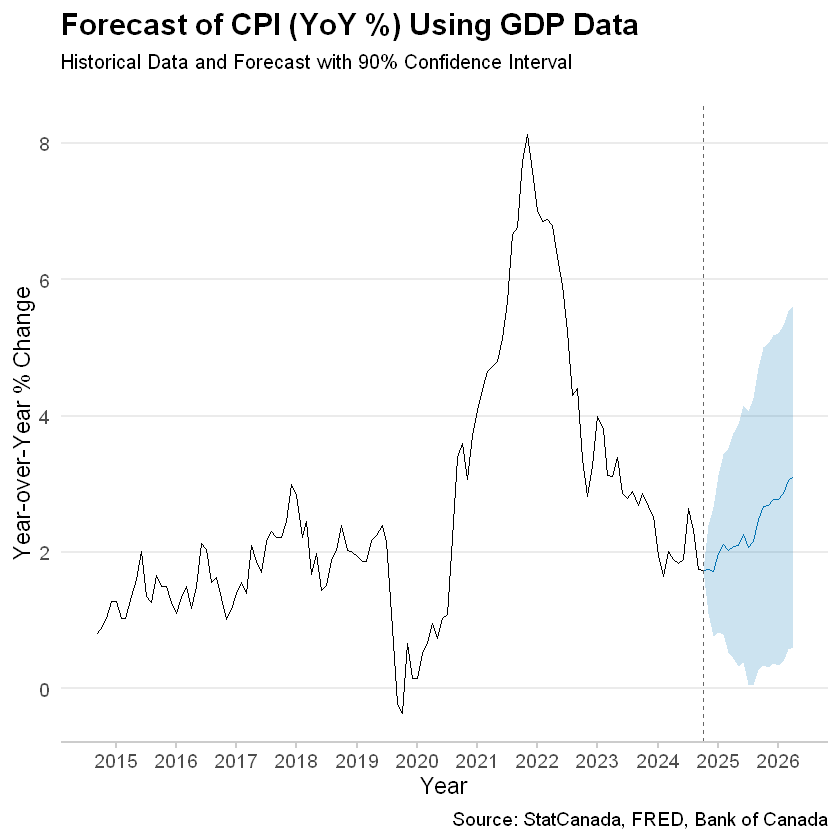

In [ ]:
last_actual_date <- forecast_df_gdp %>%
  filter(!is.na(delta_cpi) & is.na(delta_cpi.fcst)) %>%
  summarise(max_date = max(Index)) %>%
  pull(max_date)

# Determine the start date for filtering (5 years before the last actual data point)
start_date <- last_actual_date - years(10)

# Filter the dataframe to include the last 5 years of actual data plus all forecast data
plot_data <- forecast_df_gdp %>%
  filter(Index >= start_date)

# Find the date where the forecast officially begins
forecast_start_date <- plot_data %>%
  filter(!is.na(delta_cpi.fcst)) %>%
  summarise(min_date = min(Index)) %>%
  pull(min_date)

# Create the plot
ggplot(plot_data, aes(x = Index)) +
  # 1. Plot the historical data line (in black)
  geom_line(aes(y = delta_cpi), color = "black", size = 0.5, na.rm = TRUE) +
  
  # 2. Plot the forecast line (in blue)
  geom_line(aes(y = delta_cpi.fcst), color = "#0072B2", size = 0.5, na.rm = TRUE) +
  
  # 3. Add the shaded confidence interval ribbon
  geom_ribbon(aes(ymin = delta_cpi.lower, ymax = delta_cpi.upper), 
              fill = "#0072B2", 
              alpha = 0.2,    # alpha makes the ribbon transparent
              na.rm = TRUE) +
  
  # 4. Add a vertical dashed line at the start of the forecast period
  geom_vline(xintercept = as.numeric(forecast_start_date), 
             linetype = "dashed", 
             color = "grey40") +
  
  # 5. Apply labels and titles
  labs(
    title = "Forecast of CPI (YoY %) Using GDP Data",
    subtitle = "Historical Data and Forecast with 90% Confidence Interval",
    x = "Year",
    y = "Year-over-Year % Change",
    caption = "Source: StatCanada, FRED, Bank of Canada"
  ) +
  
  # 6. Customize the x-axis date format
  scale_x_date(
    date_breaks = "1 year", 
    date_labels = "%Y"
  ) +
  
  # 7. Apply a clean theme
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(face = "bold", size = 18),
    plot.subtitle = element_text(size = 12, margin = margin(b = 20)),
    panel.grid.minor = element_blank(),
    panel.grid.major.x = element_blank(),
    axis.line.x = element_line(color="grey80"),
    axis.ticks.x = element_line(color="grey80")
  )

In [ ]:
ggsave(
  "cpi_parsimonious_gdp.png", # The filename for the saved plot               # The plot object to save
  width = 10,              # Width in inches
  height = 5,              # Height in inches
  dpi = 300                # Dots per inch (resolution)
)

In [ ]:
arch_test_result <- arch.test(var_model_12, lags.multi = 5)

# Print the results
print(arch_test_result)


	ARCH (multivariate)

data:  Residuals of VAR object var_model_12
Chi-squared = 4212.2, df = 3920, p-value = 0.0006216



$arch.mul

	ARCH (multivariate)

data:  Residuals of VAR object var_model_12
Chi-squared = 4212.2, df = 3920, p-value = 0.0006216



In [ ]:

# Check the stability of the model
# All roots should be < 1
roots(var_model_12)

[1] 0.9582173 0.9582173 0.9537944 0.9537944 0.9512297 0.9512297 0.9498772
 [8] 0.9498772 0.9495281 0.9495281 0.9487897 0.9487897 0.9485096 0.9485096
[15] 0.9426663 0.9426663 0.9418431 0.9336609 0.9336609 0.9239897 0.9239897
[22] 0.9219896 0.9219896 0.9196525 0.9196525 0.9180735 0.9180735 0.9136846
[29] 0.9136846 0.9013139 0.9013139 0.9011526 0.9011526 0.9004845 0.9004845
[36] 0.8868642 0.8852414 0.8852414 0.8835902 0.8835902 0.8814223 0.8814223
[43] 0.8787726 0.8787726 0.8786738 0.8786738 0.8782595 0.8782595 0.8746097
[50] 0.8746097 0.8735931 0.8735931 0.8710439 0.8710439 0.8673237 0.8670536
[57] 0.8670536 0.8668926 0.8668926 0.8629989 0.8629989 0.8610015 0.8610015
[64] 0.8578499 0.8578499 0.8244454 0.8212901 0.8212901 0.8155477 0.8155477
[71] 0.8138961 0.8138961 0.8124029 0.8085852 0.8085852 0.8019610 0.8019610
[78] 0.7863161 0.7863161 0.7527549 0.7527549 0.4343393 0.4343393 0.0606983

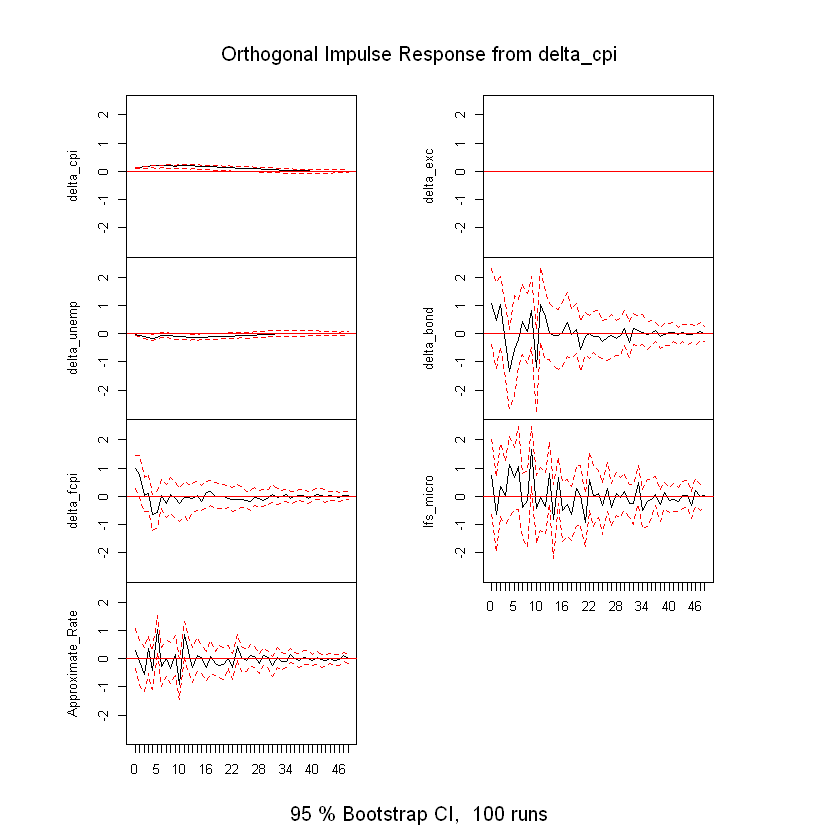

In [ ]:
irf_increase <- vars::irf(var_model_12,
                    impulse = "delta_cpi",
                    n.ahead = 48,
                    boot = TRUE)

# Plot the results
plot(irf_increase)